# Analyse de la complexité théorique des algorithmes en pratique grâce aux décorateurs

## Retour sur l'analyse du calcul de $x^n$

On rappelle ci-dessous la fonction récursive du calcul $x^n$ vue en TD.

In [1]:
def puissance(x, n): 
    res = 1.
    for _ in range(n): 
        res *= x
    return res

Le calcul du nombre de multiplications $m(n)$ nous a amené à établir le calcul suivant : $m(n) = n$.
    
Pour vérifier ce calcul théorique en pratique, on peut ajouter un compteur qu'on incrémente chaque fois qu'on réalise une multiplication. Le compteur sera une variable globale, (ré-)initialisée avant chaque appel. 

L'utilisation d'une variable globale pour le décompte d'opérations dans une fonction $f$, et non la modification du type retourné par la fonction pour laquelle on souhaite réaliser ce décompte permet de ne pas modifier la signature, et ainsi de laisser le reste du programme qui potentiellement utilise $f$ identique.

In [2]:
global cpt

def puissance(x, n): 
    global cpt
    res = 1.
    for _ in range(n):
        cpt += 1
        res *= x
    return res

In [3]:
cpt = 0
puissance(2,0)
cpt

0

In [4]:
cpt = 0
puissance(2,10)
cpt

10

Il ne faut bien sûr pas oublier de remettre le compteur à 0 avant chaque appel.

On peut alors faire varier la variable d'intérêt (ici $n$) et obtenir une courbe de complexité reflétant le nombre de multiplications (au lieu d'une courbe de temps comme on l'a fait au TP précédent). Bien sûr ici inutile de réaliser une moyenne puisque le calcul ne varie pas.

In [5]:
TAILLE_MAX = 100
def test_puissance():
    global cpt
    nombre_multiplications = []
    for n in range(TAILLE_MAX):
        cpt = 0
        puissance(2,n)
        nombre_multiplications.append(cpt)
    return nombre_multiplications
complexite_puissance = test_puissance()

In [6]:
%matplotlib inline
import pylab

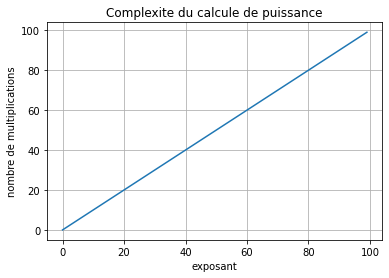

In [7]:
pylab.plot(list(range(TAILLE_MAX)), complexite_puissance)
pylab.title('Complexite du calcule de puissance')
pylab.xlabel('exposant')
pylab.ylabel('nombre de multiplications')
pylab.grid()

## Décorateurs

Il est dommage d'avoir à modifier le code des fonctions pour lesquelles on souhaite étudier le comportement.

Python (et d'autres langages) offre une possibilité consistant à indiquer que l'appel d'une fonction sera remplacé par l'appel d'une autre fonction. 

Pour ce faire on utilise le mécanisme des **décorateurs** qui consistent donc à appliquer une *décoration* à une fonction.

Voici un exemple :

In [8]:
def addition(a,b):
    return a+b

In [9]:
def decorateur(function):
    print("Je passe par ici")
    return addition

La fonction `decorateur` va décorer la fonction `multiplication`.

In [10]:
@decorateur
def multiplication(a,b):
    return a*b

Je passe par ici


Que s'est-il passé ? Grâce au `@` suivi du nom de la fonction, nous avons indiqué à Python que la fonction `multiplication` devait en fait être définie par la fonction retournée par la fonction `decorateur` (oui des fonctions peuvent prendre en paramètre des fonctions et retourner des fonctions). Donc au moment de la définition de la fonction `multiplication` c'est comme si on avait écrit `multiplication = addition`, puisque la fonction `decorateur` retourne la fonction addtion.

Et on peut vérifier ci-dessous que le résultat obtenu est alors l'addition et non la multiplication. Vous remarquerez que "Je passe par ici" n'est pas affiché lors de l'appel à `multiplication`. C'est uniquement lors de l'appel à `decorateur`, qui n'est appelé qu'une seule fois. 

In [11]:
multiplication(3,4)

7

Cet usage n'est bien sûr pas celui qui est le plus intéressant à mettre en œuvre.

Regardons maintenant comment faire pour que la fonction multiplication affiche ses opérandes au moment de son appel.

In [12]:
def decorateur(function):
    
    def fonction_interne(a,b):
        print("Les opérandes sont {} et {}".format(a,b))
        return function(a,b) 
    
    print("Je redefinis {}".format(function.__name__))
    return fonction_interne

On a ici utilisé une fonction interne à la fonction `decorateur` qui va retourner le résultat de la fonction `function` (dans notre cas `multiplication`) et aura pour effet de bord de réaliser un affichage.

Reste à décorer `multiplication`.

In [13]:
@decorateur
def multiplication(a,b):
    return a*b

Je redefinis multiplication


In [14]:
res = multiplication(3,4)
res

Les opérandes sont 3 et 4


12

Il est très intéressant de noter que je n'ai pas modifié ni la signature ni le code de la fonction `multiplication` pour aboutir à ce résultat. J'ai juste indiqué devant la défintion de la fonction `multiplication` le signe `@` suivi de la fonction permettant de redéfinir `multiplication`.

La fonction interne sera nommé *wrapper* en anglais. Cette fonction sert juste à réaliser des traitements en plus de la fonction qu'elle appelle, mais calcule la même chose. C'est un *emballage* de la fonction : à l'intérieur c'est la même chose. 

Attention que le décorateur que nous avons réalisé ici ne fonctionne que pour les fonctions à deux paramètres puisque `fonction_interne` possède deux paramètres.

On peut aussi faire la remarque que pour décorer une fonction, il faut modifier le code de la fonction pour lui ajouter le `@`. On peut s'en passer !

In [44]:
def multiplication(a,b):
    return a*b

In [45]:
multiplication(3,4)

12

In [46]:
multiplication = decorateur(multiplication)

Je redefinis multiplication


In [47]:
multiplication(3,4)

Les opérandes sont 3 et 4


12

## Retour à la complexité 

Revenons au sujet de la complexité des algorithmes. On a vu avant que l'ajout d'un compteur allait nous permettre de compter le nombre d'opération et ainsi d'avoir une approche empirique de la complexité théorique. Comment faire avec un décorateur ?

Commencons par créer un décorateur qui incrémente un compteur avant de retourner le même résultat que la fonction décorée.

In [15]:
# mon decorateur
def compteur(function):
    
    def fonction_interne(a,b):
        global cpt
        cpt += 1
        return function(a,b)
    
    return fonction_interne

Je décore la fonction pour laquelle il m'intéresse de compter le nombre d'appels.

In [16]:
@compteur
def multiplication(a,b):
    return a*b

In [17]:
def puissance(x, n): 
    res = 1.
    for _ in range(n): 
        res = multiplication(res,x)
    return res

Nous avons maintenant une fonction multiplication qui, lorsqu'elle est appelée incrémente le compteur `cpt`.

In [18]:
cpt = 0
puissance(2,12)
cpt

12

Bien sûr vous pourrez objecter que cela a nécessité de modifier le code de `puissance` puisqu'un a décoré `multiplication` et non l'opérateur `*`. Malheureusement on ne peut pas rédéfinir les opérateur sur les type primitifs. Mais cela n'enlève rien à l'intérêt de la chose.

Et maintenant, pour la calcul d'exponentiation rapide.

In [19]:
def puissance2(x, n):
    r, s, k = 1., float(x), n 
    while k != 0:
        if k % 2 == 1: 
            r = multiplication(r,s)
        s = multiplication(s,s)
        k //= 2 
    return r

In [20]:
TAILLE_MAX = 100
def test_puissance2():
    global cpt
    nombre_multiplications = []
    for n in range(1,TAILLE_MAX):
        cpt = 0
        puissance2(2,n)
        nombre_multiplications.append(cpt)
    return nombre_multiplications
complexite_puissance = test_puissance2()

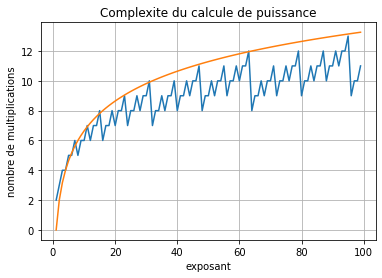

In [21]:
import numpy
x = list(range(1,TAILLE_MAX))
y = [ 2*numpy.log2(i) for i in x ]
pylab.plot(x, complexite_puissance)
pylab.plot(x, y)
pylab.title('Complexite du calcule de puissance')
pylab.xlabel('exposant')
pylab.ylabel('nombre de multiplications')
pylab.grid()

Décorer les opérateurs est particulièrement utile lorsque l'opération à compter se trouve dans une conditionnelle. Sinon il faut modifier le code pour savoir si l'opération a été réalisée ou non. Comparer les versions avec et sans décorateurs ci-dessous.

In [54]:
def compare(x, y):
    if x < y:
        return -1
    elif x > y:
        return 1
    else:
        return 0
    
def recherche_sequentielle(v,l):
    i = 0
    while i < len(l) and compare(l[i],v) != 0:
        i += 1
    return i < len(l)

Une approche souvent utilisée par les étudiants consiste à ajouter directement le compteur dans le code de la recherche. Il faut alors faire attention à savoir si l'appel à `compare` a été réalisé ou non lorsqu'on sort de la boucle.

In [55]:
def recherche_sequentielle_compteur(v,l):
    global cpt
    i = 0
    while i < len(l) and compare(l[i],v) != 0:
        cpt += 1 # si on entre dans la boucle, on a nécessairement eu un appel à compare
        i += 1
    if i < len(l):
        cpt += 1 # on a eu un appel à compare dont le résultat a été 0
    return i < len(l)

In [56]:
cpt = 0
recherche_sequentielle_compteur(2,[0,9,8,3,1,5,6,2,7])

True

In [57]:
cpt

8

Avec un décorateur :

In [58]:
compare = compteur(compare)

In [59]:
cpt = 0
recherche_sequentielle(2,[0,9,8,3,1,5,6,2,7])

True

In [60]:
cpt

8

## Revisite de la complexité théorique des tris

Reprendre le code des tris vus dans les séances précédentes et décorez la fonction `compare` comme vu ici.

Réaliser des courbes pour les 4 tris sélection, insertion, rapide, fusion pour le pire des cas. Comparer cette étude empirique avec l'étude théorique, par exemple en juxtaposant les trois courbes obtenues : temps de calcul, fonction théorique du nombre d'opérations, décompte du nombre d'opérations.

## Pour aller plus loin

On peut faire des choses encore plus évoluées en utilisant des fonctions spéciales de Python. Par exemple ne plus avoir à gérer le compteur de manière gloable. Nous n'entrerons pas dans l'explication du fonctionnement mais vous pouvez par imitation utiliser ce type de décorateur.

Le décorateur `count` présenté ici permet de compter n'importe quelle fonction, quelque soit son nombre de paramètres et sans avoir à gérer un compteur en variable globale.

In [29]:
from functools import wraps

def count(fct):
    '''
    decorator for counting  calls to  function fct
    
    :Example:

    >>> @count
    ... def fact(n):
    ...     if n == 0:
    ...         return 1
    ...     else:
    ...         return n * fact(n - 1)
    
    >>> fact.counter
    0
    >>> fact(5)
    120
    >>> fact.counter
    6
    '''
    @wraps(fct) 
    def wrapper(*args, **kwargs):
        y = fct(*args, **kwargs)
        wrapper.counter += 1
        return y
    wrapper.counter = 0
    return wrapper

In [30]:
@count
def fibo(n):
    if n == 0 or n == 1:
        return n
    return fibo(n-1) + fibo(n-2)

In [31]:
fibo(5)

5

In [32]:
fibo.counter

15

In [33]:
@count
def compare(x, y):
    if x < y:
        return -1
    elif x > y:
        return 1
    else:
        return 0
    
recherche_sequentielle(2,[0,9,8,3,1,5,6,2,7])

True

In [34]:
compare.counter

8

Calculer le nombre d'appels lors du tri fusion ou du tri rapide. 